In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix, kde_1d
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

### Setting up the pyabc run

In [2]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=17, threads_per_worker = 2)
client = Client(c,timeout=90)

In [2]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'0_4_Adults_mean': 17152.0,
 '10_4_Adults_mean': 14350.0,
 '20_4_Adults_mean': 11823.0,
 '40_4_Adults_mean': 12679.0,
 '80_4_Adults_mean': 12095.0,
 '160_4_Adults_mean': 11954.0,
 '0_5_Adults_mean': 19216.0,
 '10_5_Adults_mean': 17330.0,
 '20_5_Adults_mean': 15110.0,
 '40_5_Adults_mean': 10917.0,
 '80_5_Adults_mean': 7923.0,
 '160_5_Adults_mean': 5980.0,
 '0_6_Adults_mean': 18229.0,
 '10_6_Adults_mean': 17481.0,
 '20_6_Adults_mean': 17078.0,
 '40_6_Adults_mean': 15322.0,
 '80_6_Adults_mean': 6599.0,
 '160_6_Adults_mean': 2245.0,
 '0_7_Adults_mean': 12589.0,
 '10_7_Adults_mean': 14229.0,
 '20_7_Adults_mean': 18951.0,
 '40_7_Adults_mean': 17520.0,
 '80_7_Adults_mean': 16514.0,
 '160_7_Adults_mean': 478.0,
 '0_4_Adults_sd': 3874.0,
 '10_4_Adults_sd': 5023.0,
 '20_4_Adults_sd': 4745.0,
 '40_4_Adults_sd': 5132.0,
 '80_4_Adults_sd': 4682.0,
 '160_4_Adults_sd': 3807.0,
 '0_5_Adults_sd': 4729.0,
 '10_5_Adults_sd': 3807.0,
 '20_5_Adults_sd': 5023.0,
 '40_5_Adults_sd': 4847.0,
 '80_5_Adults_sd'

In [3]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #transformed to 0.0001 - .1
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              #AIAdultLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AIAdultLD50=(-4, -1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AIAdultSlope=(1, 9),
              #AILarvaLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AILarvaLD50=(-4,-1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [4]:
# Set our distance function and sampler
distance = pyabc.PNormDistance(p=1)
#distance = pyabc.AdaptivePNormDistance(p=2, adaptive=True, scale_type=0) #scale type is MAD (more resilient to outliers)
#df_logger = logging.getLogger('DistanceFunction')
#df_logger.setLevel(logging.DEBUG)

#distance = PNormDistance(p=2)

sampler = DaskDistributedSampler(dask_client = client)
#sampler = SingleCoreSampler()

transition = LocalTransition()

NameError: name 'client' is not defined

In [6]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(500, max_population_size = 500),
             transitions = transition,
             sampler=sampler)

In [7]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_12_20.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=1, start_time=2018-12-20 10:35:51.958089, end_time=None)>
INFO:Epsilon:initial epsilon is 332683.7999826442


1

In [8]:
history = abc.run(max_nr_populations=30, minimum_epsilon=0)

INFO:ABC:t:0 eps:332683.7999826442
INFO:ABC:t:1 eps:301254.99178891466
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:2 eps:273852.12753920275
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:3 eps:257834.77657442863
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:4 eps:242798.93385452134
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:5 eps:234059.4881322435
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:6 eps:226162.86588790314
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:7 eps:220347.5019526124
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:8 eps:215615.00312482484
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:9 eps:211393.69523475485
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:10 eps:207956.81093811287
INFO:Adaptation:Change nr particles 500 -> 500


KeyboardInterrupt: 

In [ ]:
pop_data = history.get_all_populations()
pop_data

In [ ]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}%".format(gen+1,particles/samples*100))

In [ ]:
history.total_nr_simulations

### Visualize results

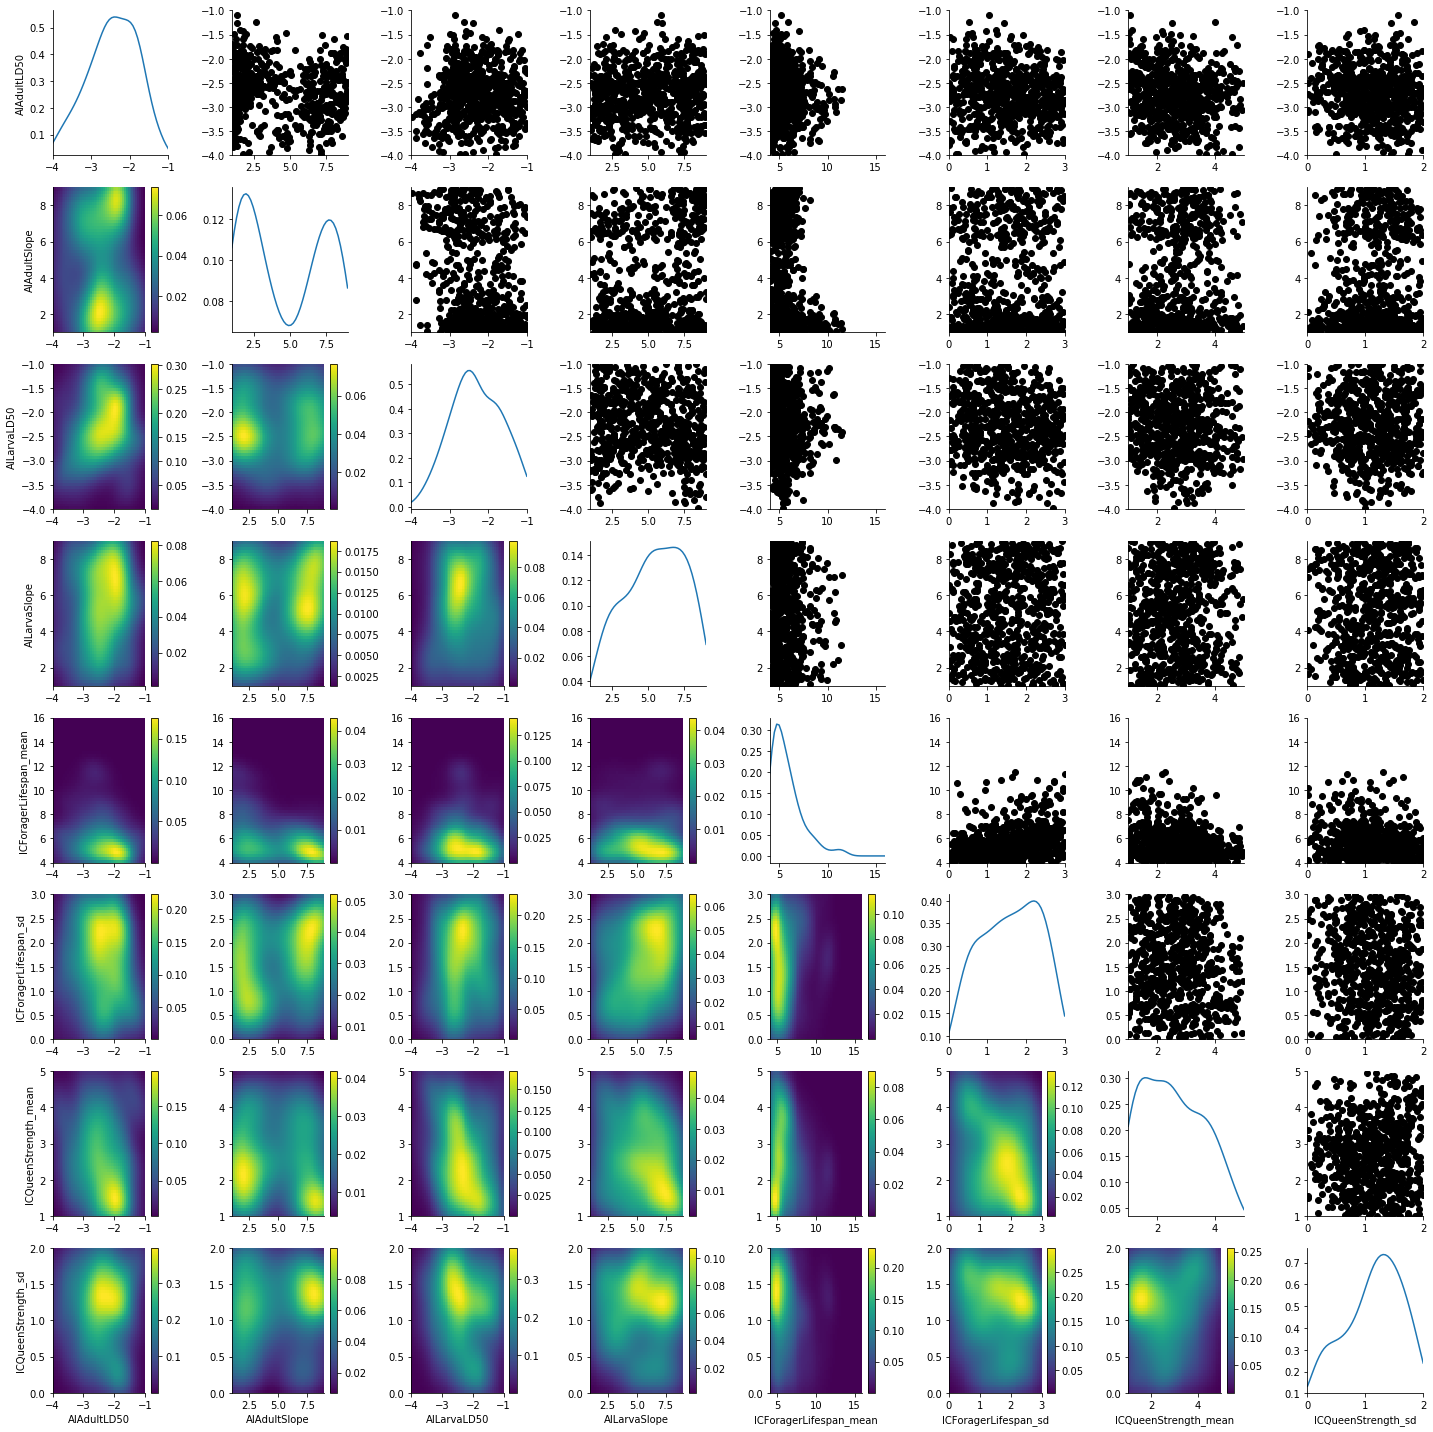

In [7]:
df, w = history.get_distribution(m=0, t=12)
plot_kde_matrix(df, w, limits=limits);

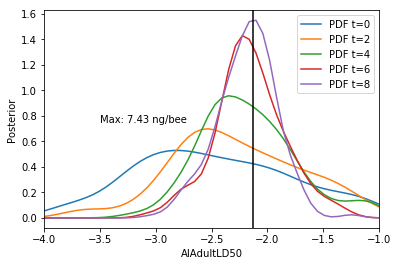

In [14]:
variable = 'AIAdultLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,2):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=-4, xmax=-1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
ax.annotate('Max: {:.2f} ng/bee'.format(10**MAP.item()*1000), xy = (-3.5,0.75))
plt.show()

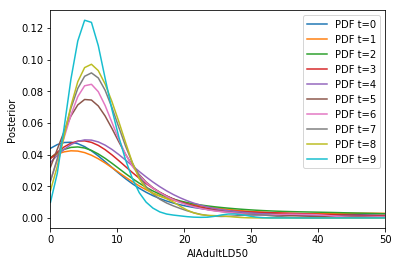

In [15]:
variable = 'AIAdultLD50'
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    df[[variable]] = 10**df[[variable]].copy() * 1000 #unlog transform and convert go ng/bee
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=50,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
ax.legend()
plt.show()

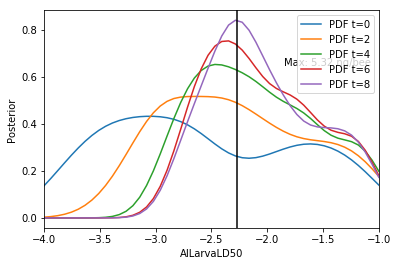

In [16]:
variable = 'AILarvaLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,2):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=-4, xmax=-1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} ng/bee'.format(10**MAP.item()*1000), xy = (-1.85,0.65))
plt.show()

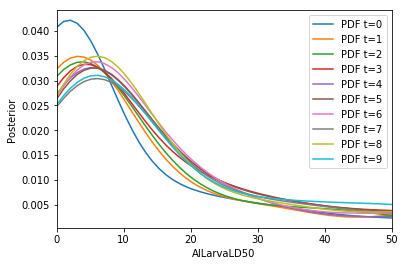

In [17]:
variable = 'AILarvaLD50'
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    df[[variable]] = 10**df[[variable]].copy() * 1000 #unlog transform and convert go ng/bee
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=50,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
ax.legend()
plt.show()

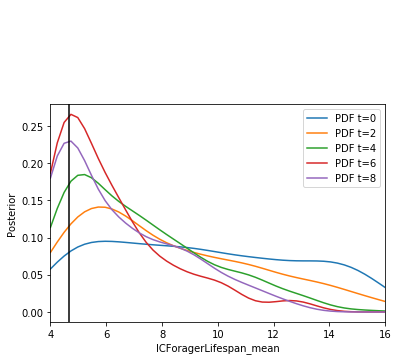

In [18]:
variable = 'ICForagerLifespan_mean'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,2):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=4, xmax=16,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} days'.format(MAP.item()), xy = (5.5,0.4))
ax.legend()
plt.show()

### Visualize from a stored run

In [6]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_12_20.db"))
history = History(db_path)
history.id = 1

In [7]:
history

In [10]:
df, w = history.get_distribution(m=0, t=9)

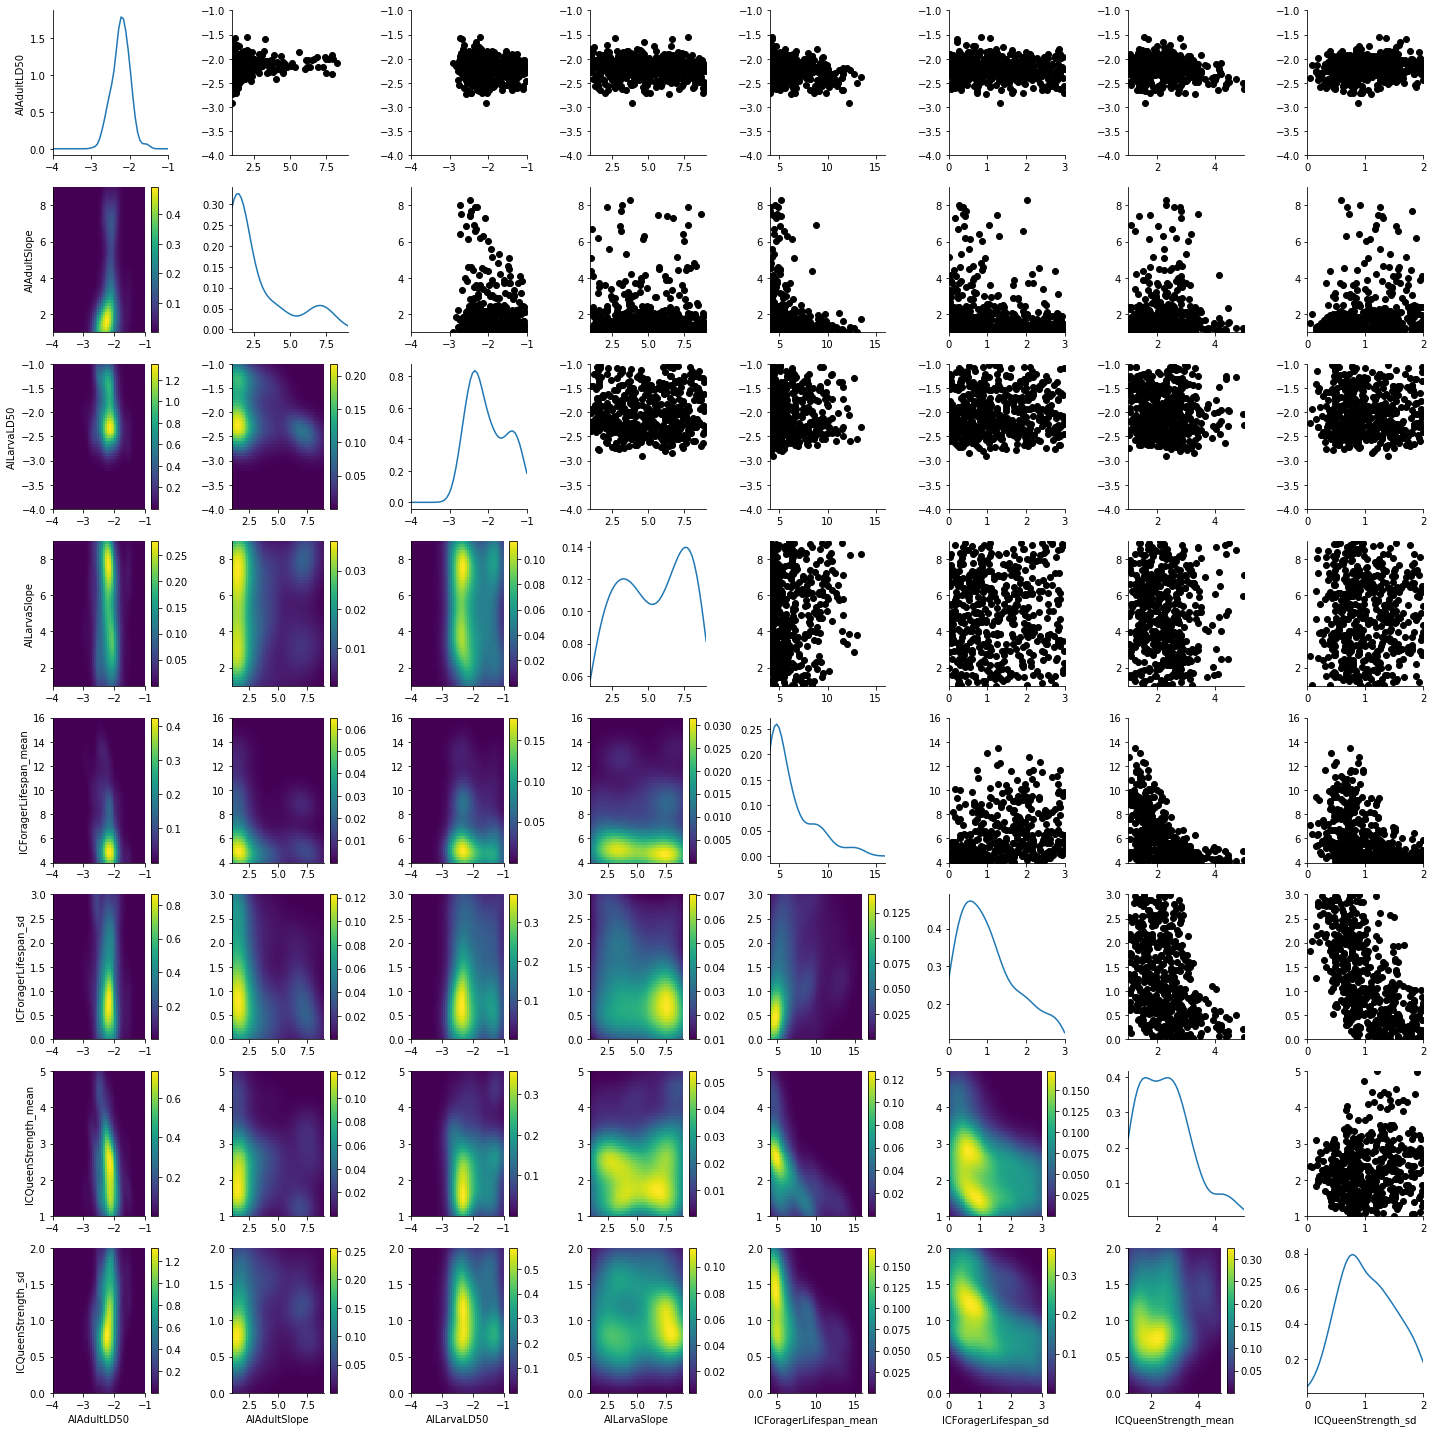

In [11]:
plot_kde_matrix(df, w, limits=limits);

In [45]:
df

name,AIAdultLD50,AIAdultSlope,AILarvaLD50,AILarvaSlope,ICForagerLifespan_mean,ICForagerLifespan_sd,ICQueenStrength_mean,ICQueenStrength_sd
id,,,,,,,,
303,-2.685636,8.094345,-1.772840,5.406513,14.553191,0.657079,3.449022,1.267300
304,-2.663545,6.648187,-1.451895,5.516439,13.541263,1.298367,4.598010,1.923057
305,-2.829690,5.112503,-1.767447,7.463796,13.834600,0.846625,4.239668,1.554032
306,-2.582455,7.101485,-2.014743,4.465162,14.222965,0.471162,3.354573,1.982290
307,-2.842316,7.089738,-2.690495,4.839774,15.594149,0.451034,4.609429,1.665724
308,-2.635456,7.884031,-1.836026,7.646172,13.272350,1.156771,1.976554,0.801624
309,-2.508028,8.440665,-2.146109,3.999631,14.399742,1.306812,3.333596,1.412176
310,-2.841345,6.523990,-1.562820,5.604397,14.675542,0.643028,2.680901,1.041421
311,-2.798456,7.773063,-2.223311,4.389313,14.535816,0.919606,3.942047,1.605260


In [7]:
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-21 13:00:49.506982,0,0.000000,1
1,0,2018-11-22 03:23:25.736873,1050,45093.710464,500
2,1,2018-11-22 20:29:59.210061,1852,43829.242970,700
3,2,2018-11-23 20:26:20.513080,2597,42429.560910,700
4,3,2018-11-25 13:45:38.166100,3575,41384.001976,700
5,4,2018-11-27 05:17:31.478573,4416,41349.192336,700
6,5,2018-11-28 19:39:04.627983,4426,41368.095419,700
7,6,2018-12-02 11:57:03.569684,3882,44891.364807,700
8,7,2018-12-04 07:18:16.336575,4710,43520.700319,700
9,8,2018-12-05 21:40:29.710463,2941,42327.206485,700


In [14]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-20 16:41:20.170554, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-11-20 16:50:58.666070, end_time=2018-11-21 05:07:04.583930)>,
 <ABCSMC(id=3, start_time=2018-11-21 13:00:46.200087, end_time=None)>]

In [12]:
#get the maximum a posteriori estimation for AdultLD50
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
adult_ld50_map = (10**MAP.item()) * 1000 #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
adult_ld50_median = (10**x.item(np.min(np.where(cdf > .5))))*1000 #un-log transformed and converted to ng/bee
print('Adult LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(adult_ld50_map, adult_ld50_median))

# calculate 95% credible interval
adult_ld50_lower = (10**x.item(np.min(np.where(cdf > .025))))*1000
adult_ld50_upper = (10**x.item(np.min(np.where(cdf > .975))))*1000
print("95% CI: {} - {}".format(adult_ld50_lower, adult_ld50_upper))

Adult LD50 MAP: 6.30 ng/bee, median: 6.01 ng/bee
95% CI: 1.9693365514258003 - 15.867114600828181


In [13]:
#get the maximum a posteriori estimation for LarvaLD50
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
larva_ld50_map = (10**MAP.item()) * 1000 #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
larva_ld50_median = (10**x.item(np.min(np.where(cdf > .5))))*1000 #un-log transformed and converted to ng/bee
print('Larva LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(larva_ld50_map, larva_ld50_median))

# calculate 95% credible interval
larva_ld50_lower = (10**x.item(np.min(np.where(cdf > .025))))*1000
larva_ld50_upper = (10**x.item(np.min(np.where(cdf > .975))))*1000
print("95% CI: {} - {}".format(larva_ld50_lower, larva_ld50_upper))

Larva LD50 MAP: 4.51 ng/bee, median: 7.60 ng/bee
95% CI: 1.6177658002833533 - 76.66762450479006


In [22]:
np.median(df['AIAdultLD50']), np.mean(df['AIAdultLD50'])

(-2.0314253778131577, -2.0758233732186047)

In [23]:
np.median(df['AILarvaLD50']), np.mean(df['AILarvaLD50'])

(-2.0912470255757527, -2.027425371456056)

### Continuing a stopped run

In [8]:
#retrieve stored run 
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_20.db"))
#db = History(db_path)
#db.id = 3

In [9]:
# define the ABCSMC object
abc_cont = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(700, max_population_size = 700),
             transitions = transition,
             sampler=sampler)

In [10]:
abc_cont.load(db_path,3)

INFO:Epsilon:initial epsilon is 42327.20648517324


3

In [11]:
abc_cont.run(minimum_epsilon=0, max_nr_populations=8)

INFO:ABC:t:8 eps:42327.20648517324
INFO:Adaptation:Change nr particles 700 -> 700
INFO:ABC:t:9 eps:39600.58758252634
INFO:Adaptation:Change nr particles 700 -> 700
INFO:ABC:t:10 eps:52174.84127273418
INFO:Adaptation:Change nr particles 700 -> 700
INFO:ABC:t:11 eps:49501.45554930588
INFO:Adaptation:Change nr particles 700 -> 700
INFO:ABC:t:12 eps:44335.03247239168
INFO:Adaptation:Change nr particles 700 -> 700
INFO:ABC:t:13 eps:40450.04367332869
INFO:Adaptation:Change nr particles 700 -> 700


KeyboardInterrupt: 